# Importing necessary libraries


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

# Visualizing Data
As we can see our data is distributed evenly 25k positive reviews and 25k negative reviews count plot is shown in the figure.

Positive reviews are 25000 and negative reviews are 25000 of total 50000 


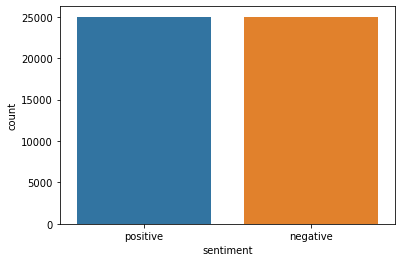

In [2]:
dataset = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
negative = len(dataset[dataset['sentiment']=='positive'])
positive = len(dataset) - negative
sns.countplot(dataset['sentiment'])
print('Positive reviews are {} and negative reviews are {} of total {} '.format(positive,negative,len(dataset)))

Converting the labels positve and negative as 1,0 so that they can be fed to the neural network to predict whether the given review is a positive or negative. Splitting of data 80% for the training and remaining 20% for testing.

In [3]:
le = LabelEncoder()
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(dataset['review'].values,dataset['sentiment'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

# Pre-Processing The Text
Using tokenizer to produce token for a given word and taking maximum length of 200 character of a review and after we simply truncate the input review and then padded the input to max len of 200. 

In [4]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)
train_pad_sequence = pad_sequences(training_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 112195


# Using glove vectors for embedding

In [5]:
embedded_words = {}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [6]:
embedding_matrix = np.zeros((len(word_index) + 1,200))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Creating The Model
layer1: Embedding Layer using glove weights 

layer2: Using a Bidirectional LSTM

layer3: A dropout Layer

layer4: A Dense layer of 256 neurons with 'relu' activation

layer5: A Dense Layer of 128 neurons with 'relu' activation

layer6: Again a dropout layer. 

layer7: Sigmoid activation layer to classify it positive and negative.


In [7]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,200,weights=[embedding_matrix],input_length=200,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          22439200  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               135680    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [9]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = 'accuracy')
history = model.fit(train_pad_sequence,training_labels,epochs = 30 ,validation_data=(test_pad_sequence,testing_labels))

Epoch 1/30
1250/1250 [==============================] - 126s 101ms/step - loss: 0.5315 - accuracy: 0.7350 - val_loss: 0.4167 - val_accuracy: 0.8080
Epoch 2/30
1250/1250 [==============================] - 126s 101ms/step - loss: 0.3788 - accuracy: 0.8369 - val_loss: 0.3422 - val_accuracy: 0.8542
Epoch 3/30
1250/1250 [==============================] - 129s 104ms/step - loss: 0.3331 - accuracy: 0.8589 - val_loss: 0.3089 - val_accuracy: 0.8675
Epoch 4/30
1250/1250 [==============================] - 126s 101ms/step - loss: 0.1410 - accuracy: 0.9462 - val_loss: 0.3848 - val_accuracy: 0.8694
Epoch 13/30
1250/1250 [==============================] - 131s 104ms/step - loss: 0.1286 - accuracy: 0.9521 - val_loss: 0.4034 - val_accuracy: 0.8746
Epoch 14/30
1250/1250 [==============================] - 126s 101ms/step - loss: 0.1118 - accuracy: 0.9589 - val_loss: 0.4032 - val_accuracy: 0.8748
Epoch 15/30
1250/1250 [==============================] - 126s 101ms/step - loss: 0.1003 - accuracy: 0.9635 - v

# Plotting Accuracy and Losses

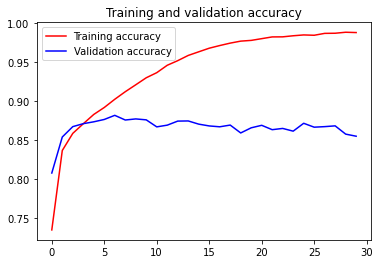

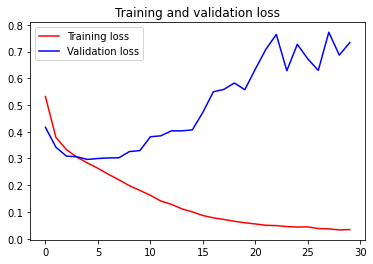

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [11]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.9886000156402588
Validation Accuracy: 0.8820000290870667


# Conclusion

1 - We have great accuracy and we can increase it training for much longer and tune other hyperparameters
2 - DNN LSTM have a deep impact on NLP problems and we can see that this model performs quite well.